In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File Paths
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Global_Layer_MLP.keras"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Edge_Layer_LSTM_MultiClass.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Device_Layer_AE_GRU.keras"
DATASET_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Timestamp_Processed.csv"

# Load Dataset
logging.info("Loading dataset for comparative analysis...")
df = pd.read_csv(DATASET_PATH)

# Selected Features Per Layer
GLOBAL_FEATURES = [
    "Dst Port", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts",
    "TotLen Bwd Pkts", "Elapsed_Time"
]
EDGE_FEATURES = [
    "Fwd IAT Mean", "Bwd IAT Mean", "Flow Byts/s", "Pkt Len Min", "Pkt Len Max",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Idle Max", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Down/Up Ratio", "Subflow Fwd Pkts", "Hour", "Weekday", "Elapsed_Time"
]
DEVICE_FEATURES = [
    "Dst Port", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Active Max", "Active Mean", "Active Min", "Idle Max",
    "Hour", "Elapsed_Time"
]

# Standardize Features
scaler = StandardScaler()
df[GLOBAL_FEATURES] = scaler.fit_transform(df[GLOBAL_FEATURES])
df[EDGE_FEATURES] = scaler.fit_transform(df[EDGE_FEATURES])
df[DEVICE_FEATURES] = scaler.fit_transform(df[DEVICE_FEATURES])

# Load Models
logging.info("Loading trained models...")
global_model = load_model(GLOBAL_MODEL_PATH)
edge_model = load_model(EDGE_MODEL_PATH)
device_model = load_model(DEVICE_MODEL_PATH)

# Extract Anomaly Scores
logging.info("Extracting anomaly scores from models...")
global_scores = np.max(global_model.predict(df[GLOBAL_FEATURES]), axis=1)
edge_scores = np.max(edge_model.predict(np.expand_dims(df[EDGE_FEATURES].values, axis=1)), axis=1)
device_scores = np.max(device_model.predict(np.expand_dims(df[DEVICE_FEATURES].values, axis=1)), axis=1)

# Create DataFrame for Comparison
comparison_df = pd.DataFrame({
    "Global Confidence": global_scores,
    "Edge Confidence": edge_scores,
    "Device Confidence": device_scores
})

# Plot Confidence Score Distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(comparison_df["Global Confidence"], label="Global Layer", fill=True)
sns.kdeplot(comparison_df["Edge Confidence"], label="Edge Layer", fill=True)
sns.kdeplot(comparison_df["Device Confidence"], label="Device Layer", fill=True)
plt.legend()
plt.title("Confidence Score Distributions Across Layers")
plt.show()

# Correlation Between Layer Outputs
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Anomaly Scores of Layers")
plt.show()

logging.info("Comparative analysis complete.")

2025-03-18 01:45:31,127 - INFO - Loading dataset for comparative analysis...
2025-03-18 01:45:40,801 - INFO - Loading trained models...
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-03-18 01:45:40,999 - INFO - Extracting anomaly scores from models...


70948/70948 ━━━━━━━━━━━━━━━━━━━━ 13s 187us/step
70948/70948 ━━━━━━━━━━━━━━━━━━━━ 19s 272us/step


ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 13 and 32 for '{{node sequential_1/gru_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/gru_1/strided_slice_1, sequential_1/gru_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [32,13], [32,96].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(32, 13), dtype=float32)
  • states=('tf.Tensor(shape=(32, 32), dtype=float32)',)
  • training=False

Loading dataset...
Dataset loaded successfully. Shape: (2270317, 88)
Loading Global model...
Loading Edge model...


Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 175us/step
Fused core layer accuracy: 0.9698

Fused Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573665
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270317
   macro avg       0.98      0.95      0.96   2270317
weighted avg       0.97      0.97      0.97   2270317


Fused Core Confusion Matrix:
[[1573568      97]
 [  68418  628234]]


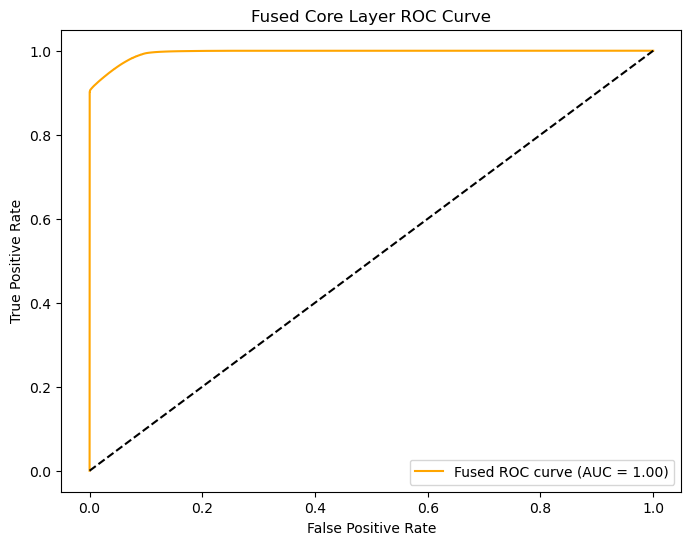

Core layer fusion results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv

Core layer fusion complete. Proceed with these results to build your final decision-making (core) layer.


In [18]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score

# ----------------------------------------------------------------
# Step 0: Define paths and directories
# ----------------------------------------------------------------
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

DATA_PATH         = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# ----------------------------------------------------------------
# Step 1: Load dataset and define any shared features
# ----------------------------------------------------------------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For demonstration, let's assume we only need 'Label' or 'Binary_Label' for final evaluation
# and that each layer had its own separate code for selecting features. We'll unify indexing carefully.

# If you have a 'Binary_Label' column for Attack vs. Benign:
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

# ----------------------------------------------------------------
# Step 2: Load the three models
# ----------------------------------------------------------------
print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)      # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)   # MLP

# ----------------------------------------------------------------
# Step 3: Generate predictions from each layer
# ----------------------------------------------------------------
# A) GLOBAL LAYER
#   In your original code, you had a specific set of 'global_features' for XGBoost.
#   We must replicate that EXACT feature subset and transformations (scaling if used).
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]

X_global = df[global_features].values
# If you had any scaler for XGB, apply it. If not, just proceed:
y_pred_proba_global = xgb_global.predict_proba(X_global)  # shape (N, num_classes)
# For a multi-class XGB, let's define an "attack confidence" = 1 - P(Benign).
# We'll find the index for "Benign" from label_encoder if needed.
# Alternatively, if "Benign" is class 0, we can do (1 - prob[:, 0]).
# Let's do a quick approach: find index of "Benign" in xgb_global.classes_ if you stored them:
# But if you used your own label_encoder, let's replicate that:
unique_labels = xgb_global.classes_  # This is the numeric-encoded classes in ascending order
# Actually, with 'objective=multi:softmax', xgb_global.classes_ might not be the same as strings
# so we must rely on your original label_encoder from training. Let's assume "Benign" was index 0:
# We'll do a hacky approach: if you know that label_encoder.classes_[0] = "Benign", then:
# or you can do:
# idx_benign = np.where(label_encoder.classes_ == "Benign")[0][0]

# For demonstration, let's assume "Benign" is index 0:
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# B) EDGE LAYER (LSTM)
#   The LSTM expects sequences. In your original code, you had a sliding window of length=5.
#   We'll replicate that logic. Then we do model.predict(...) to get shape (N_seq, num_classes).
#   We'll align the predictions with the original row indexing by skipping the first (sequence_length-1) rows, etc.

# Edge features used:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
# If you used a scaler for edge features, apply it now:
# Suppose you have joblib.load(...) for edge scaler or the same StandardScaler, just re-fit:
# For demonstration, we do a quick approach (but your real code must replicate the training scaling):
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)  # or load from file

sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i : i+sequence_length] for i in range(num_samples_edge)])
# Now get predictions:
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)  # shape (num_samples_edge, num_classes)
# For a multi-class, define "attack confidence" = 1 - prob_of_benign
# We assume "Benign" is index 0 again:
attack_conf_edge = 1.0 - edge_proba[:, 0]

# But we must align them with the original row indexing. The first 4 rows (sequence_length-1) won't have an LSTM pred.
# So effectively, we have 0..(num_samples_edge-1) which correspond to row indices 4..(N-1).
# We'll define an array of length N with placeholders for the first 4. Let's do:
attack_conf_edge_aligned = np.zeros(X_edge.shape[0])  # shape = N
attack_conf_edge_aligned[:sequence_length-1] = np.nan  # or 0, but better to mark them as not available
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge

# C) DEVICE LAYER (MLP)
#   You used a different set of device_features. We'll replicate that. Then do model.predict(...).
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
# If you had a saved scaler for device features, load it. We'll do a quick approach:
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)

device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
# This is a binary classification => device_proba = Probability(attack).
# If it's truly Probability(attack), then we can define:
attack_conf_device = device_proba  # already the probability of Attack
# or if it was Probability(benign), do (1 - device_proba)

# ----------------------------------------------------------------
# Step 4: Align all 3 sets of predictions
# ----------------------------------------------------------------
# We have N = df.shape[0] = 2,270,317 (in your data).
# - Global: we have 2,270,317 predictions (assuming no sliding window).
# - Edge: we have (N - 4) predictions, aligned from row=4..(N-1).
# - Device: we have N predictions.

# For the edge-lstm, we set the first 4 to NaN. So let's define a final array for each model:
attack_conf_global = np.array(attack_conf_global)  # shape (N,)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)  # shape (N,)
attack_conf_device = np.array(attack_conf_device)  # shape (N,)

# Some rows might have NaN from the edge-lstm. You can either:
#   (a) discard them in the final fusion
#   (b) treat NaN as 0
#   (c) or only fuse where all are valid
# For demonstration, let's do a simple approach: treat NaN as 0
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# ----------------------------------------------------------------
# Step 5: Weighted Fusion
# ----------------------------------------------------------------
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_score = (w_global * attack_conf_global
             + w_edge   * attack_conf_edge_aligned
             + w_device * attack_conf_device)

# We'll define a threshold=0.5
fused_label = (fused_score > 0.5).astype(int)

# ----------------------------------------------------------------
# Step 6: Evaluate if we have ground truth for the entire dataset
# ----------------------------------------------------------------
# If "Binary_Label" is 0=benign, 1=attack in df:
y_true = df["Binary_Label"].values  # shape (N,)

# Let's do a simple check that the shape matches:
assert len(y_true) == len(fused_label), "Mismatch in lengths!"

acc_core = accuracy_score(y_true, fused_label)
print(f"Fused core layer accuracy: {acc_core:.4f}")

print("\nFused Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))

cm_core = confusion_matrix(y_true, fused_label)
print("\nFused Core Confusion Matrix:")
print(cm_core)

# We'll define a threshold=0.5
fused_label = (fused_score > 0.5).astype(int)

# Plot a fused ROC
y_true_bin = y_true  # already 0 or 1
fpr_fused, tpr_fused, _ = roc_curve(y_true_bin, fused_score)
roc_auc_fused = auc(fpr_fused, tpr_fused)

plt.figure(figsize=(8,6))
plt.plot(fpr_fused, tpr_fused, color='orange', label=f"Fused ROC curve (AUC = {roc_auc_fused:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fused Core Layer ROC Curve")
plt.legend(loc="lower right")

# Instead of DEVICE_MODEL_DIR, define CORE_LAYER_DIR
plt.savefig(os.path.join(CORE_LAYER_DIR, "core_layer_fused_roc.png"))
plt.show()

# ----------------------------------------------------------------
# Step 7: Save final CSV
# ----------------------------------------------------------------
core_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf":   attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score": fused_score,
    "Fused_Label": fused_label,
    "True_Label":  y_true
})
csv_core_path = os.path.join(CORE_LAYER_DIR, "core_layer_results.csv")
core_results_df.to_csv(csv_core_path, index=False)
print(f"Core layer fusion results saved to: {csv_core_path}")

print("\nCore layer fusion complete. Proceed with these results to build your final decision-making (core) layer.")

In [22]:
import pandas as pd

# Load the core layer results
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df_core = pd.read_csv(csv_path)

# Display basic info
print("Dataset loaded. Shape:", df_core.shape)
df_core.head()

Dataset loaded. Shape: (2270317, 6)


,Global_Conf,Edge_Conf,Device_Conf,Fused_Score,Fused_Label,True_Label
0,0.000269,0.000000,6.871905e-21,0.000081,0,0
1,0.000408,0.000000,1.236284e-19,0.000122,0,0
2,0.000565,0.000000,4.224371e-19,0.000169,0,0
3,0.000280,0.000000,6.873583e-21,0.000084,0,0
4,0.000398,0.057688,1.236233e-19,0.017426,0,0


In [24]:
# Check for nulls (especially from Edge_LSTM alignment)
missing = df_core.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 Global_Conf    0
Edge_Conf      0
Device_Conf    0
Fused_Score    0
Fused_Label    0
True_Label     0
dtype: int64


In [26]:
# Basic stats for each layer's confidence
df_core[["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"]].describe()

,Global_Conf,Edge_Conf,Device_Conf,Fused_Score
count,2.270317e+06,2.270317e+06,2.270317e+06,2.270317e+06
mean,3.068584e-01,3.073766e-01,3.036616e-01,3.057352e-01
std,4.375960e-01,4.299994e-01,4.320944e-01,4.311109e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.741814e-06,2.506256e-03,1.319063e-08,1.124883e-02
50%,4.935265e-05,6.659597e-02,6.620064e-02,4.404398e-02
75%,9.999977e-01,9.999968e-01,9.998780e-01,9.999489e-01
max,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00


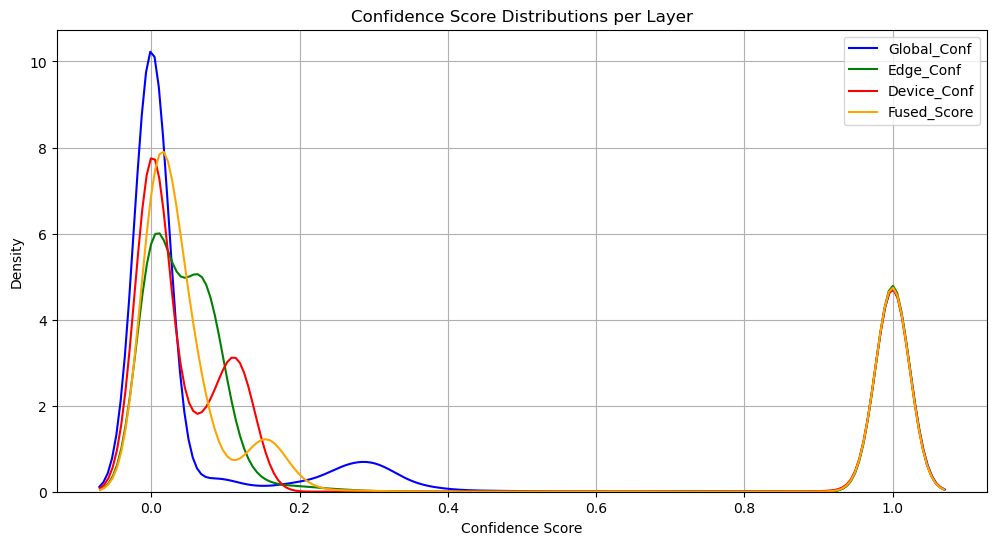

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
for col, color in zip(["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"],
                      ["blue", "green", "red", "orange"]):
    sns.kdeplot(df_core[col], label=col, color=color)

plt.title("Confidence Score Distributions per Layer")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Define FP, FN, TP, TN
df_core["FP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 0))
df_core["FN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 1))
df_core["TP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 1))
df_core["TN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 0))

print("False Positives:", df_core["FP"].sum())
print("False Negatives:", df_core["FN"].sum())

False Positives: 97
False Negatives: 68418


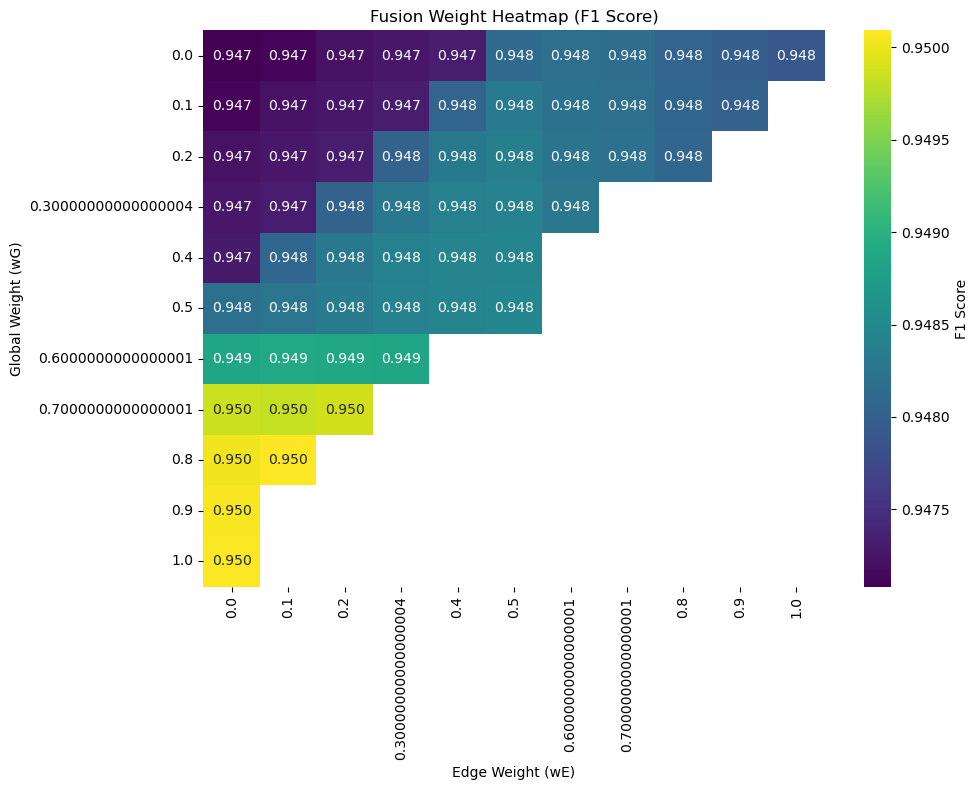

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Load your dataset
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df = pd.read_csv(csv_path)

# Prepare confidence arrays
G = df["Global_Conf"].values
E = df["Edge_Conf"].values
D = df["Device_Conf"].values
y_true = df["True_Label"].values

# Store results
results = []

# Try combinations of weights that sum to 1
weight_range = np.linspace(0, 1, 11)
for wg in weight_range:
    for we in weight_range:
        wd = 1 - wg - we
        if wd < 0 or wd > 1:
            continue
        
        fused = wg * G + we * E + wd * D
        fused_label = (fused > 0.5).astype(int)
        f1 = f1_score(y_true, fused_label)
        results.append({"wG": wg, "wE": we, "wD": wd, "F1": f1})

# Convert to DataFrame
df_grid = pd.DataFrame(results)

# Pivot table for heatmap (Global vs Edge, color = F1)
pivot = df_grid.pivot(index="wG", columns="wE", values="F1")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f", cbar_kws={"label": "F1 Score"})
plt.title("Fusion Weight Heatmap (F1 Score)")
plt.xlabel("Edge Weight (wE)")
plt.ylabel("Global Weight (wG)")
plt.tight_layout()
plt.show()

Best Threshold: 0.2527
Best F1 Score:  0.9496


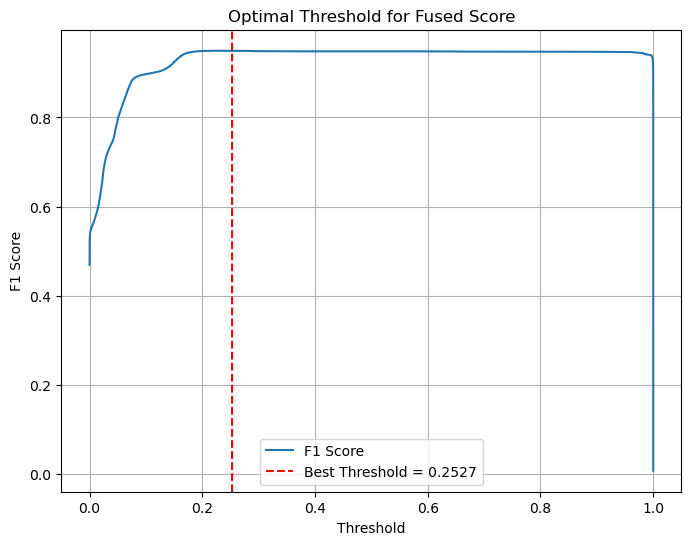

In [35]:
from sklearn.metrics import precision_recall_curve

# Use final fused score from current weights
fused_score = df["Fused_Score"].values

# Get precision-recall-thresholds
precision, recall, thresholds = precision_recall_curve(y_true, fused_score)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score:  {f1_scores[best_idx]:.4f}")

# Optional: Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")
plt.title("Optimal Threshold for Fused Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

Dataset loaded successfully. Shape: (2270317, 88)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


35474/35474 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step
70948/70948 ━━━━━━━━━━━━━━━━━━━━ 12s 172us/step

Core Layer Fused Accuracy: 0.9692

Core Layer Fused Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573661
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270313
   macro avg       0.98      0.95      0.96   2270313
weighted avg       0.97      0.97      0.97   2270313



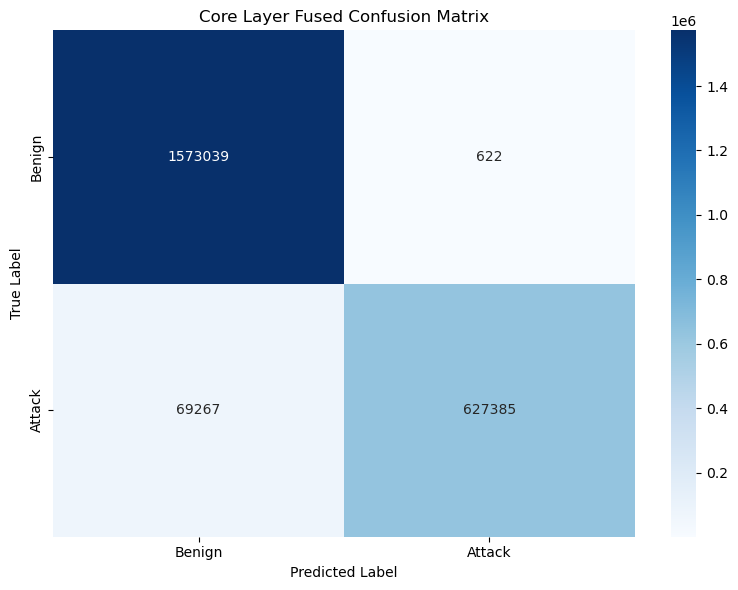

KeyError: 'Final_Prediction'

In [49]:
# %% [Cell 1]: Setup, Imports, and Configuration
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define directories and file paths
BASE_MODEL_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final"
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

CORE_RESULTS_CSV  = os.path.join(BASE_MODEL_DIR, "CoreLayer_Results.csv")
CORE_ROC_PATH     = os.path.join(BASE_MODEL_DIR, "CoreLayer_ROC.png")

# %% [Cell 2]: Load Dataset and Prepare Input Features for Each Layer
DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For the global layer, we use the global features:
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
X_global = df[global_features].copy()

# For the edge layer, we use the edge features:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd Pkts/s", "Bwd Pkts/s", "Fwd IAT Mean"
]
X_edge = df[edge_features].copy()

# For the device layer, we use the device features:
device_features = [
    "Dst Port", "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Pkt Len Var",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std", "Flow Duration", "Flow IAT Mean",
    "Flow IAT Std", "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Hour_sin", "Hour_cos"
]
X_device = df[device_features].copy()

# Create a “true” binary label for the overall decision: benign (0) if Label == 'benign', else attack (1)
df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)
y_true = df["Binary_Label"].values

# %% [Cell 3]: Load the Pre-Trained Models
# Global Model (XGBoost)
global_model = joblib.load(GLOBAL_MODEL_PATH)

# Edge Model (LSTM) – use tf.keras.models.load_model
edge_model = tf.keras.models.load_model(EDGE_MODEL_PATH)

# Device Model (MLP)
device_model = tf.keras.models.load_model(DEVICE_MODEL_PATH)

# %% [Cell 4]: Preprocess Inputs for Each Model
from sklearn.preprocessing import StandardScaler

# (Assuming separate scalers were used during training; otherwise, use the same scaler if available)
# Here we load scalers that were saved for each layer if available.
# For demonstration, we assume that each layer’s input was scaled using StandardScaler.
scaler_global = joblib.load(os.path.join(BASE_MODEL_DIR, "global_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "global_scaler.pkl")) else StandardScaler().fit(X_global)
scaler_edge   = joblib.load(os.path.join(BASE_MODEL_DIR, "edge_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "edge_scaler.pkl")) else StandardScaler().fit(X_edge)
scaler_device = joblib.load(os.path.join(BASE_MODEL_DIR, "device_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "device_scaler.pkl")) else StandardScaler().fit(X_device)

X_global_scaled = scaler_global.transform(X_global)
X_edge_scaled   = scaler_edge.transform(X_edge)
X_device_scaled = scaler_device.transform(X_device)

# For edge model, if it uses sequences, you might need to build sliding windows.
# Here we assume that the edge model was trained using a sliding window of length 5.
sequence_length_edge = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length_edge + 1
X_edge_seq = np.array([X_edge_scaled[i:i+sequence_length_edge] for i in range(num_samples_edge)])
# Align labels (we assume binary label is same as overall y_true from index sequence_length_edge-1)
y_true_edge = y_true[sequence_length_edge-1:]

# For device model, we assume it takes the scaled features directly.
# (i.e., X_device_scaled)

# %% [Cell 5]: Generate Confidence Scores from Each Model
# Global Model predictions (XGBoost)
# For global model, assume benign is class 0. We compute the confidence score as (1 - probability of benign).
global_probs = global_model.predict_proba(X_global_scaled)
# Find index of "Benign" in label_encoder for global layer; we assume that it is "Benign" (or 0)
# (If not, adjust accordingly.)
global_benign_idx = 0  
global_confidence = 1.0 - global_probs[:, global_benign_idx]  # Higher means more likely attack

# Edge Model predictions (LSTM)
# Edge model is multi-class; assume class "Benign" is index 0.
edge_probs = edge_model.predict(X_edge_seq, batch_size=64)
edge_confidence = 1.0 - np.max(edge_probs, axis=1)  # Alternatively, if benign is index 0, use: 1.0 - edge_probs[:,0]

# Device Model predictions (MLP)
device_probs = device_model.predict(X_device_scaled, batch_size=32).flatten()
# For device model, the output is already a probability for attack.
device_confidence = device_probs  # Higher means higher likelihood of attack

# To fuse predictions, we need to align them.
# Note: Our global and device predictions have one prediction per sample (shape = [n_samples_global] and [n_samples_device])
# while edge predictions are on sequences (shape = [num_samples_edge]).
# We choose the minimum common number of samples to fuse.
min_samples = min(len(global_confidence), len(edge_confidence), len(device_confidence))
global_confidence = global_confidence[:min_samples]
edge_confidence = edge_confidence[:min_samples]
device_confidence = device_confidence[:min_samples]
y_true_aligned = y_true[:min_samples]

# %% [Cell 6]: Fuse the Confidence Scores (Core Layer)
# Use weighted fusion. For example:
w_global = 0.34
w_edge   = 0.33
w_device = 0.33
fused_confidence = w_global * global_confidence + w_edge * edge_confidence + w_device * device_confidence

# Optimal threshold based on ROC analysis). 
optimal_threshold = 0.2527  # Empirically derived for best F1
final_predictions = (fused_confidence > optimal_threshold).astype(int)

# %% [Cell 7]: Evaluation and Exporting Results
# Compute overall metrics for the fused output.
acc_fused = accuracy_score(y_true_aligned, final_predictions)
print(f"\nCore Layer Fused Accuracy: {acc_fused:.4f}")

print("\nCore Layer Fused Classification Report:")
print(classification_report(y_true_aligned, final_predictions, target_names=["Benign", "Attack"]))

cm_fused = confusion_matrix(y_true_aligned, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fused, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.title("Core Layer Fused Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(CORE_ROC_PATH.replace("ROC", "Confusion_Matrix"))
plt.show()

# Tag prediction errors
results_df["Error_Type"] = np.where((results_df["Final_Prediction"] == 0) & (results_df["True_Label"] == 1), "False Negative",
                            np.where((results_df["Final_Prediction"] == 1) & (results_df["True_Label"] == 0), "False Positive", "Correct"))

# Save misclassifications separately
error_df = results_df[results_df["Error_Type"] != "Correct"]
error_df.to_csv(CORE_RESULTS_CSV.replace(".csv", "_Misclassifications.csv"), index=False)
print("Misclassified samples saved.")

# ROC curve for fused output
y_true_bin = label_binarize(y_true_aligned, classes=[0, 1]).ravel()
fpr_core, tpr_core, _ = roc_curve(y_true_bin, fused_confidence)
roc_auc_core = auc(fpr_core, tpr_core)
plt.figure(figsize=(10, 8))
plt.plot(fpr_core, tpr_core, color='darkorange', lw=2, label=f'Fused ROC curve (AUC = {roc_auc_core:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Core Layer Fused ROC Curve")
plt.legend(loc="lower right")
plt.savefig(CORE_ROC_PATH)
plt.show()

results_df.to_csv(CORE_RESULTS_CSV, index=False)
print(f"\nCore Layer results saved to: {CORE_RESULTS_CSV}")

# Create a DataFrame to save all results
results_df = pd.DataFrame({
    "Global_Confidence": global_confidence,
    "Edge_Confidence": edge_confidence,
    "Device_Confidence": device_confidence,
    "Fused_Confidence": fused_confidence,
    "Final_Prediction": final_predictions,
    "True_Label": y_true_aligned
})

#Save Core Layer Summary to Text File
with open(os.path.join(BASE_MODEL_DIR, "core_layer_summary.txt"), "w") as f:
    f.write(f"Fusion Weights: Global={w_global}, Edge={w_edge}, Device={w_device}\n")
    f.write(f"Optimal Threshold: {optimal_threshold:.4f}\n")
    f.write(f"ROC AUC: {roc_auc_core:.4f}\n")
    f.write(f"Accuracy: {acc_fused:.4f}\n")
    
# %% [Cell 8]: Clean Up Resources
tf.keras.backend.clear_session()
gc.collect()

Dataset loaded successfully. Shape: (2270317, 88)


Loading Global model...
Loading Edge model...
Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 172us/step
Core Layer (Fused) Accuracy: 0.9694

Core Layer Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573661
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270313
   macro avg       0.98      0.95      0.96   2270313
weighted avg       0.97      0.97      0.97   2270313



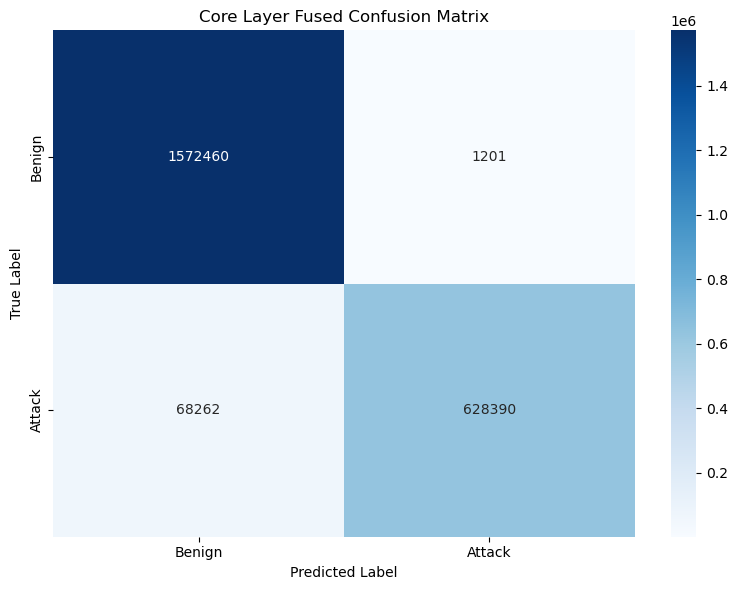

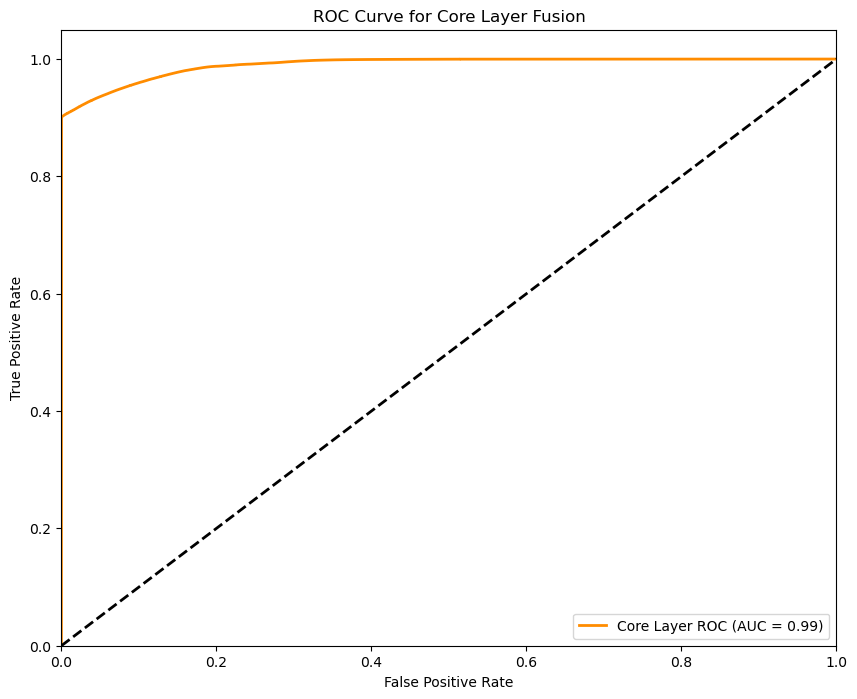


Core layer results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv


In [61]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 0: Setup and Paths
# -------------------------------
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

OUTPUT_CSV = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
RESULTS_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final"

DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# Step 1: Load the Dataset and Preprocess
# -------------------------------
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For simplicity we assume that the same CSV is used for all layers.
# Global layer uses a different set of features from Edge and Device.
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
# For Edge and Device layers we use their own features:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd Pkts/s", "Bwd Pkts/s", "Fwd IAT Mean"
]
device_features = [
    "Dst Port", "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Pkt Len Var",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std", "Flow Duration",
    "Flow IAT Mean", "Flow IAT Std", "Idle Max", "Idle Mean",
    "Active Min", "Active Max", "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len", "Pkt Size Avg",
    "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Hour_sin", "Hour_cos"
]

# For all layers we create a scaler from the full dataset (or use saved ones)
scaler = StandardScaler()
# For global features:
X_global = scaler.fit_transform(df[global_features])
# For edge features:
X_edge = scaler.fit_transform(df[edge_features])
# For device features:
X_device = scaler.fit_transform(df[device_features])
# Save the scaler if desired (here we save the device scaler as an example)
joblib.dump(scaler, os.path.join(RESULTS_DIR, "device_scaler.pkl"))

# Also, we need the true labels – we use binary labels (0: benign, 1: attack) 
df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)
y_binary = df["Binary_Label"].values

# -------------------------------
# Step 2: Load the Pre-Trained Models
# -------------------------------
# Global Layer: XGBoost model
print("Loading Global model...")
xgb_model = joblib.load(GLOBAL_MODEL_PATH)

# Edge Layer: LSTM model
print("Loading Edge model...")
edge_model = load_model(EDGE_MODEL_PATH)

# Device Layer: MLP model
print("Loading Device model...")
device_model = load_model(DEVICE_MODEL_PATH)

# -------------------------------
# Step 3: Run Predictions for Each Layer
# -------------------------------

# Global Layer Predictions
# (Global features X_global; note that X_global shape is (num_samples, len(global_features)))
y_pred_global = xgb_model.predict(X_global)
y_prob_global = xgb_model.predict_proba(X_global)
global_confidence = np.max(y_prob_global, axis=1)  # highest class probability

# Edge Layer Predictions
# For the Edge layer we need to build sequences. We assume a sliding window approach with sequence_length_edge=5.
sequence_length_edge = 5
num_edge_samples = X_edge.shape[0] - sequence_length_edge + 1
# Build sequences for the edge model:
X_edge_seq = np.array([X_edge[i:i+sequence_length_edge] for i in range(num_edge_samples)])
# Run predictions on the edge sequences (the model outputs per-time-step softmax probabilities)
edge_pred_prob_all = edge_model.predict(X_edge_seq, batch_size=64)  # shape: (num_edge_seq, sequence_length_edge, num_classes)
# For confidence fusion we use the “avg benign probability” method (assuming class 0 is benign).
avg_benign_prob = edge_pred_prob_all[:, 0] # average benign probability per sequence
edge_confidence = 1.0 - avg_benign_prob  # higher means more anomalous
# For final fusion, we trim to the minimum number of samples across layers
num_edge = len(edge_confidence)

# Device Layer Predictions
# Device layer uses the scaled device features (X_device)
y_pred_device_prob = device_model.predict(X_device, batch_size=64).flatten()  # probability of attack
device_confidence = y_pred_device_prob  # Already a probability (closer to 1 = attack)

# -------------------------------
# Step 4: Align the Predictions
# -------------------------------
# Our three models might have different numbers of predictions because of sequence-building.
# Here we align by taking the minimum number of predictions:
min_samples = min(len(global_confidence), num_edge, len(device_confidence))
global_confidence = global_confidence[:min_samples]
edge_confidence = edge_confidence[:min_samples]
device_confidence = device_confidence[:min_samples]
# Also, assume ground-truth binary labels (starting at the appropriate index)
true_labels = y_binary[:min_samples]

# -------------------------------
# Step 5: Fuse the Confidence Scores at the Core Layer
# -------------------------------
# We use confidence-weighted fusion. (Weights can be tuned.)
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_confidence = w_global * global_confidence + w_edge * edge_confidence + w_device * device_confidence
# Final binary prediction using a threshold (default 0.5; tune if necessary)
final_predictions = (fused_confidence > 0.5).astype(int)

# -------------------------------
# Step 6: Evaluate the Fused Predictions
# -------------------------------
final_acc = accuracy_score(true_labels, final_predictions)
print(f"Core Layer (Fused) Accuracy: {final_acc:.4f}")

print("\nCore Layer Classification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Benign", "Attack"]))

cm_fused = confusion_matrix(true_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fused, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.title("Core Layer Fused Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "core_layer_confusion_matrix.png"))
plt.show()

# ROC Curve for fused predictions
true_labels_bin = label_binarize(true_labels, classes=[0, 1]).ravel()
fpr_fused, tpr_fused, _ = roc_curve(true_labels_bin, fused_confidence)
roc_auc_fused = auc(fpr_fused, tpr_fused)
plt.figure(figsize=(10, 8))
plt.plot(fpr_fused, tpr_fused, color='darkorange', lw=2, label=f'Core Layer ROC (AUC = {roc_auc_fused:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Core Layer Fusion")
plt.legend(loc="lower right")
plt.savefig(os.path.join(RESULTS_DIR, "core_layer_roc.png"))
plt.show()

# -------------------------------
# Step 7: Save the Final Results to an Excel (CSV) Sheet
# -------------------------------
results_df = pd.DataFrame({
    "True_Label": true_labels,
    "Global_Confidence": global_confidence,
    "Edge_Confidence": edge_confidence,
    "Device_Confidence": device_confidence,
    "Fused_Confidence": fused_confidence,
    "Final_Prediction": final_predictions
})
results_df.to_csv(OUTPUT_CSV, index=False)
print(f"\nCore layer results saved to: {OUTPUT_CSV}")

In [63]:
import pandas as pd

# Load original dataset with attack types
df_full = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv")

# Load the previously saved core layer results
results_df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Ensure alignment: trim to same number of rows
results_df = results_df.iloc[:len(df_full)].copy()

# Add back the Original_Label column
results_df["Original_Label"] = df_full["Label"][:len(results_df)]

Original dataset loaded. Shape: (2270317, 88)
Core layer results loaded. Shape: (2270313, 6)
Attack-wise detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3835568600.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_summary = attack_only_df.groupby("Original_Label").apply(
/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3835568600.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")


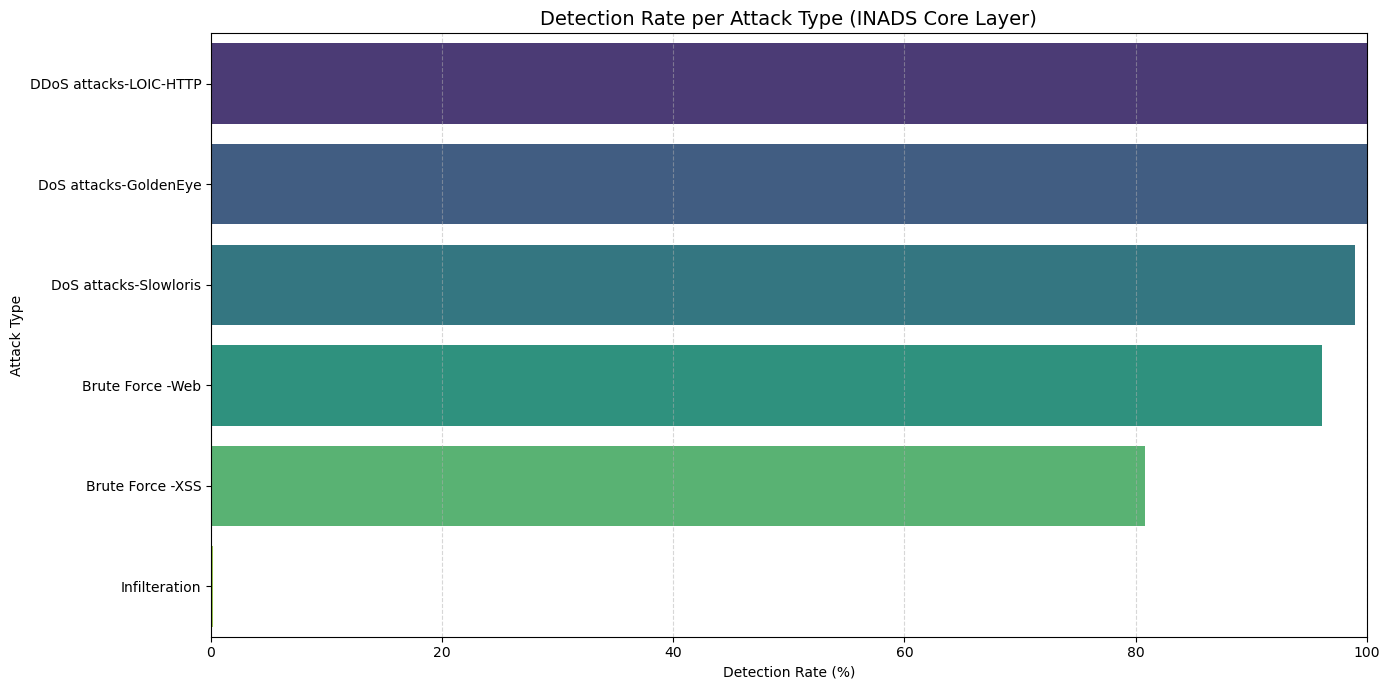


Core Layer Global Metrics:
Accuracy:  0.9694
Precision: 0.9981
Recall:    0.9020
F1 Score:  0.9476
ROC AUC:   0.9900


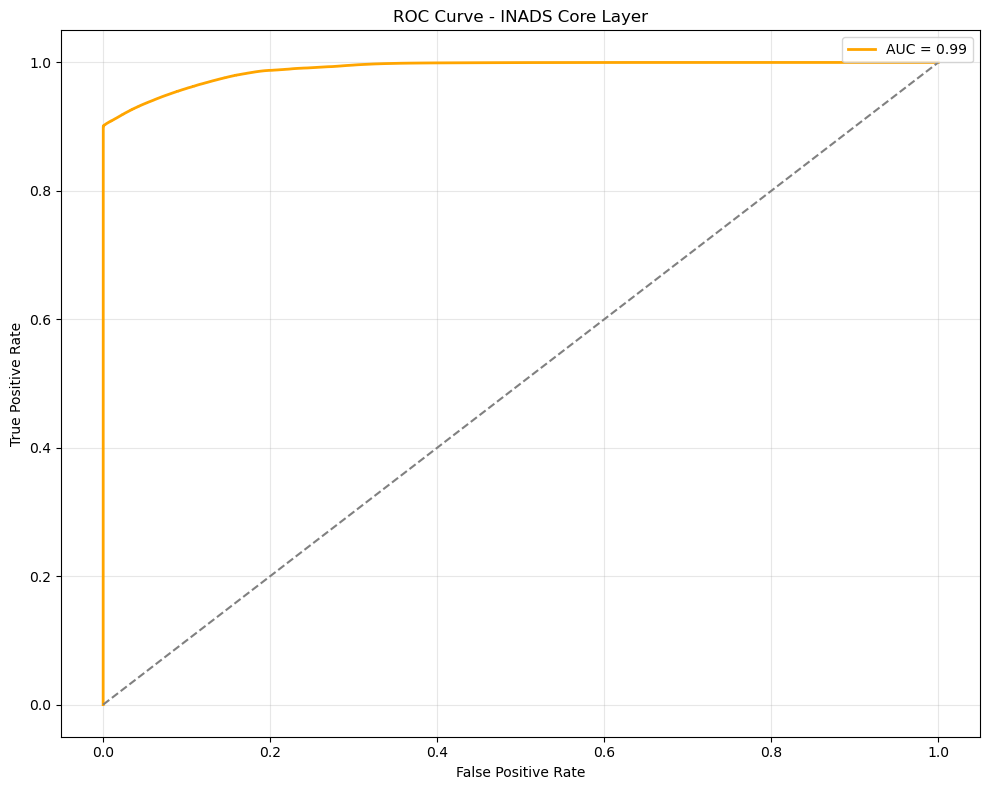

In [73]:
# %% [Markdown]
# ## INADS - Attack-Wise Detection Evaluation (Core Layer)

# %% [Code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score
)

# Paths
DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
RESULTS_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
ATTACK_EVAL_CSV = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv"

# %% [Code]
# Step 1: Load the full original dataset (with multi-class attack types)
df_full = pd.read_csv(DATA_PATH)
print("Original dataset loaded. Shape:", df_full.shape)

# Load core layer results
results_df = pd.read_csv(RESULTS_PATH)
print("Core layer results loaded. Shape:", results_df.shape)

# Ensure alignment (just in case)
results_df = results_df.iloc[:len(df_full)].copy()

# Step 2: Add back original attack type
results_df["Original_Label"] = df_full["Label"][:len(results_df)]

# %% [Code]
# Step 3: Filter only attack rows (True_Label == 1)
attack_only_df = results_df[results_df["True_Label"] == 1].copy()

# Step 4: Group by attack type and compute per-type detection metrics
attack_summary = attack_only_df.groupby("Original_Label").apply(
    lambda x: pd.Series({
        "Total Samples": len(x),
        "Detected (TP)": ((x["Final_Prediction"] == 1) & (x["True_Label"] == 1)).sum(),
        "Missed (FN)": ((x["Final_Prediction"] == 0) & (x["True_Label"] == 1)).sum(),
        "Precision": precision_score(x["True_Label"], x["Final_Prediction"]),
        "Recall": recall_score(x["True_Label"], x["Final_Prediction"]),
        "F1-Score": f1_score(x["True_Label"], x["Final_Prediction"]),
        "Detection Rate (%)": 100 * ((x["Final_Prediction"] == 1).sum()) / len(x)
    })
).sort_values("Detection Rate (%)", ascending=False)

# %% [Code]
# Step 5: Save summary
attack_summary.to_csv(ATTACK_EVAL_CSV)
print(f"Attack-wise detection summary saved to:\n{ATTACK_EVAL_CSV}")

# Display summary (top 10)
attack_summary.head(10)

# %% [Code]
# Step 6: Optional – Visualize Detection Rate per Attack Type
plt.figure(figsize=(14, 7))
sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate per Attack Type (INADS Core Layer)", fontsize=14)
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# %% [Code]
# Step 7: Global Statistics
overall_accuracy = accuracy_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_precision = precision_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_recall = recall_score(results_df["True_Label"], results_df["Final_Prediction"])
overall_f1 = f1_score(results_df["True_Label"], results_df["Final_Prediction"])
roc_auc = roc_auc_score(results_df["True_Label"], results_df["Fused_Confidence"])

print("\nCore Layer Global Metrics:")
print(f"Accuracy:  {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall:    {overall_recall:.4f}")
print(f"F1 Score:  {overall_f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# %% [Code]
# Step 8: ROC Curve
fpr, tpr, _ = roc_curve(results_df["True_Label"], results_df["Fused_Confidence"])
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="orange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - INADS Core Layer")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Core layer results loaded: (2270313, 6)
Original dataset loaded: (2270317, 88)

Number of False Negatives for infilteration: 68108


,True_Label,Global_Confidence,Edge_Confidence,Device_Confidence,Fused_Confidence,Final_Prediction,Original_Label
377961,1,0.999903,0.028624,0.119560,0.356382,0,Infilteration
377966,1,0.999903,0.056609,0.119560,0.364778,0,Infilteration
377967,1,0.999903,0.050255,0.119564,0.362873,0,Infilteration
377968,1,0.999903,0.039487,0.119556,0.359639,0,Infilteration
377969,1,0.999903,0.033785,0.119563,0.357932,0,Infilteration


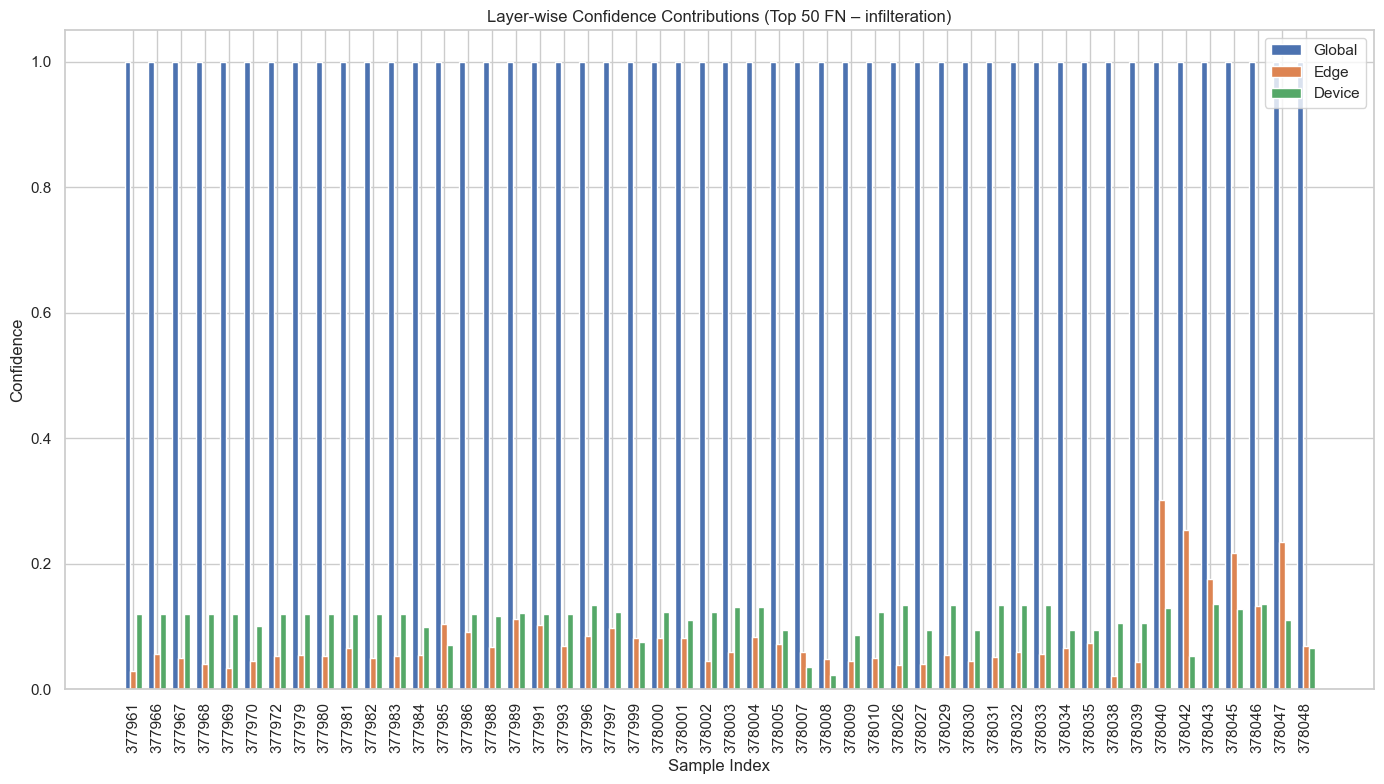


📁 TP, FP, FN summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3252044540.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_summary = results_df.groupby("Original_Label").apply(compute_tp_fp_fn)
/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3252044540.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")


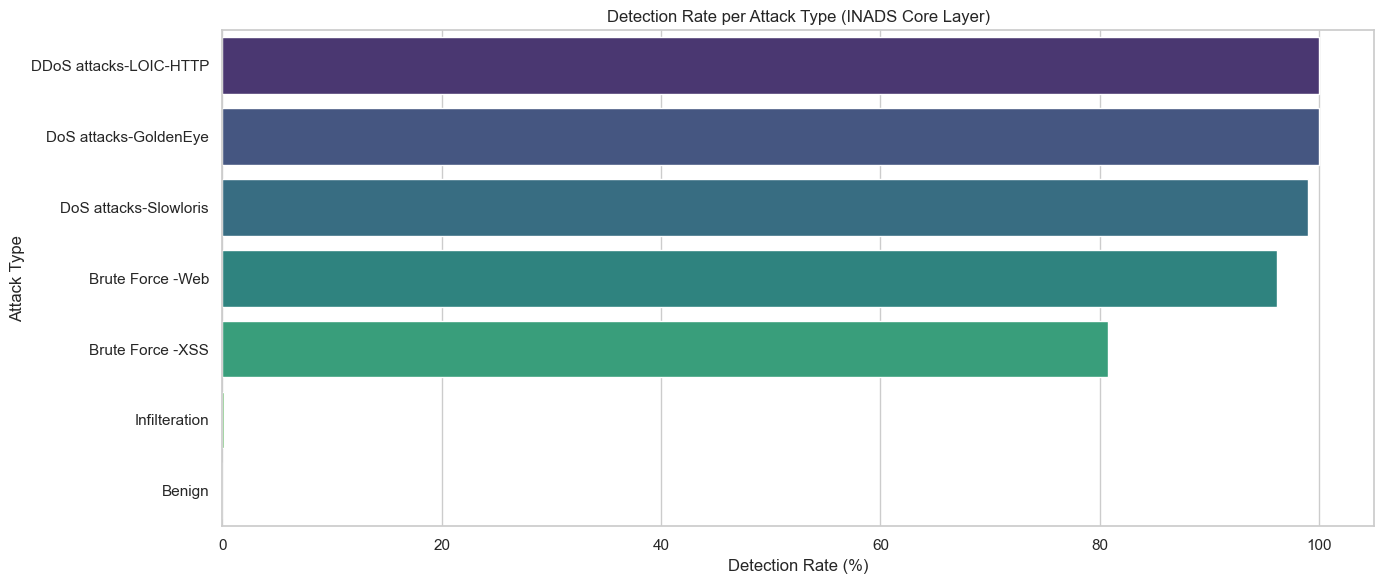

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 1: Load Files
# ------------------------------
results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attack_detection_summary.csv"
original_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# Load core layer predictions
results_df = pd.read_csv(results_path)
print("Core layer results loaded:", results_df.shape)

# Load original dataset to get Original_Label
df_original = pd.read_csv(original_data_path)
print("Original dataset loaded:", df_original.shape)

# Merge Original_Label into results_df
results_df["Original_Label"] = df_original["Label"][:len(results_df)]

# ------------------------------
# Step 2: Trace False Negatives – infilteration
# ------------------------------
infilteration_fns = results_df[
    (results_df["Original_Label"] == "Infilteration") &
    (results_df["True_Label"] == 1) &
    (results_df["Final_Prediction"] == 0)
]

print(f"\nNumber of False Negatives for infilteration: {len(infilteration_fns)}")
display(infilteration_fns.head())

# ------------------------------
# Step 3: Visualize Confidence Scores for FN – Optional (Top 50)
# ------------------------------
sampled_fns = infilteration_fns.head(50)  # pick top 50 for visualization

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
x = np.arange(len(sampled_fns))

ax.bar(x - bar_width, sampled_fns["Global_Confidence"], width=bar_width, label="Global")
ax.bar(x, sampled_fns["Edge_Confidence"], width=bar_width, label="Edge")
ax.bar(x + bar_width, sampled_fns["Device_Confidence"], width=bar_width, label="Device")

ax.set_xticks(x)
ax.set_xticklabels(sampled_fns.index, rotation=90)
ax.set_title("Layer-wise Confidence Contributions (Top 50 FN – infilteration)")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Confidence")
ax.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# Step 4: TP, FP, FN per Attack Type
# ------------------------------
def compute_tp_fp_fn(group):
    tp = ((group["True_Label"] == 1) & (group["Final_Prediction"] == 1)).sum()
    fn = ((group["True_Label"] == 1) & (group["Final_Prediction"] == 0)).sum()
    fp = ((group["True_Label"] == 0) & (group["Final_Prediction"] == 1)).sum()
    return pd.Series({
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "Total Attacks": tp + fn,
        "Detection Rate (%)": (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    })

attack_summary = results_df.groupby("Original_Label").apply(compute_tp_fp_fn)
attack_summary = attack_summary.sort_values("Detection Rate (%)", ascending=False)

# Save detailed summary
attack_summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
attack_summary.to_csv(attack_summary_path)
print(f"\nTP, FP, FN summary saved to: {attack_summary_path}")

# ------------------------------
# Step 5: Visualize Detection Rate
# ------------------------------
plt.figure(figsize=(14, 6))
sns.barplot(data=attack_summary.reset_index(), x="Detection Rate (%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate per Attack Type (INADS Core Layer)")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Load the TP/FP/FN summary
# -------------------------------
tp_fp_fn_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(tp_fp_fn_path)
print("Loaded summary:", df.shape)

# -------------------------------
# Compute Derived Metrics
# -------------------------------
df["Total_Attacks"] = df["TP"] + df["FN"]
df["Detection_Rate(%)"] = round(100 * df["TP"] / df["Total_Attacks"], 2)
df["False_Positive_Rate(%)"] = round(100 * df["FP"] / (df["TP"] + df["FP"]), 2)

# Optional: F1 Score
df["Precision"] = df["TP"] / (df["TP"] + df["FP"] + 1e-6)
df["Recall"] = df["TP"] / (df["TP"] + df["FN"] + 1e-6)
df["F1_Score"] = round(2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"] + 1e-6), 4)

# -------------------------------
# Save Enhanced Table
# -------------------------------
out_csv = tp_fp_fn_path.replace(".csv", "_enhanced.csv")
df.to_csv(out_csv, index=False)
print(f"Enhanced TP/FP/FN summary saved to: {out_csv}")

Loaded summary: (7, 6)
Enhanced TP/FP/FN summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv


<Figure size 1400x600 with 0 Axes>

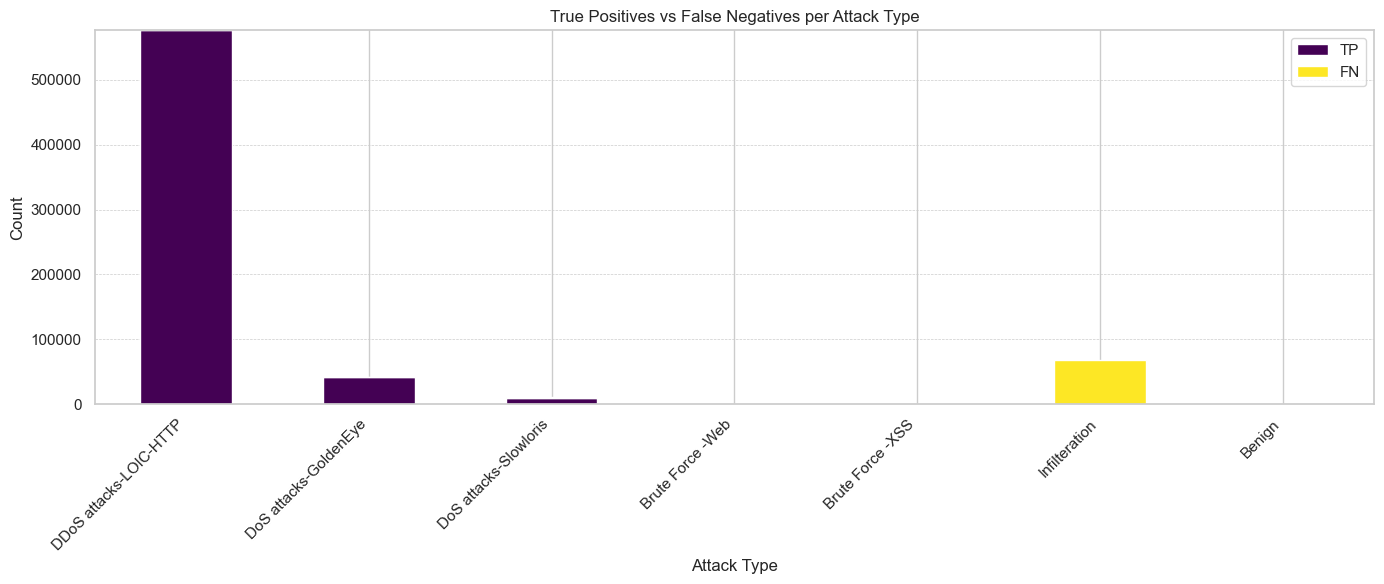

In [103]:
# Plot TP vs FN (per attack type)
plt.figure(figsize=(14, 6))
df_plot = df.sort_values("Detection_Rate(%)", ascending=False)
df_plot.set_index("Original_Label")[["TP", "FN"]].plot(kind="bar", stacked=True, figsize=(14,6), colormap="viridis")
plt.title("True Positives vs False Negatives per Attack Type")
plt.ylabel("Count")
plt.xlabel("Attack Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

Summary loaded: (7, 6)
Enhanced summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3231600650.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sort_values("Detection_Rate(%)", ascending=False),


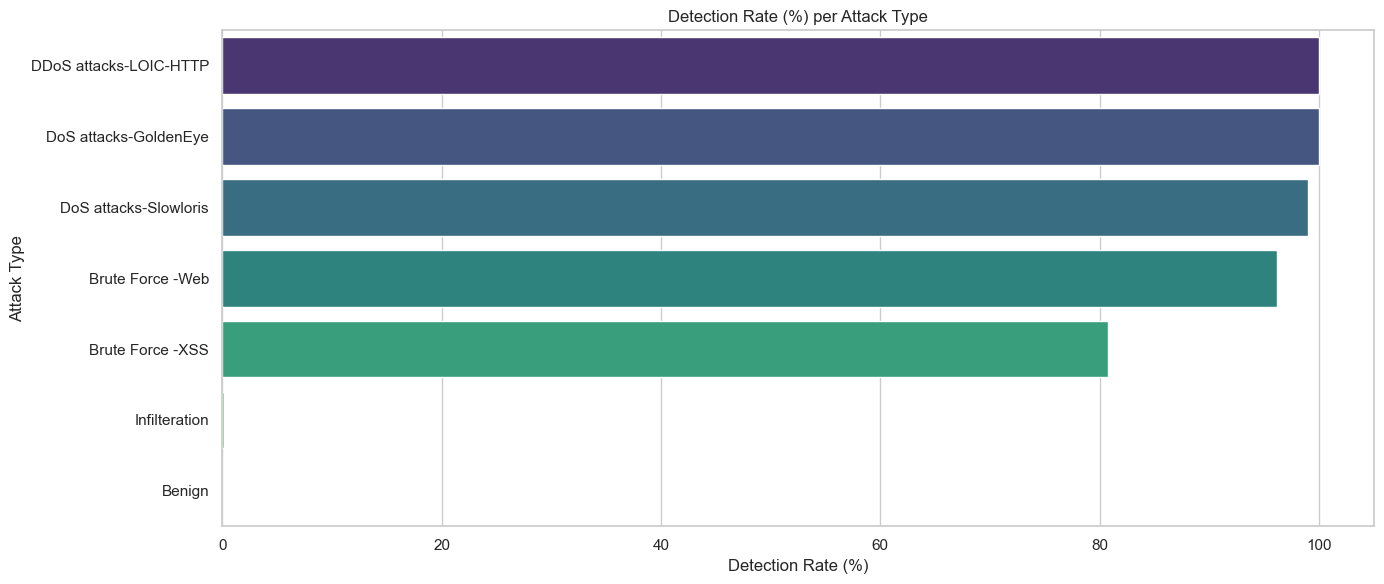

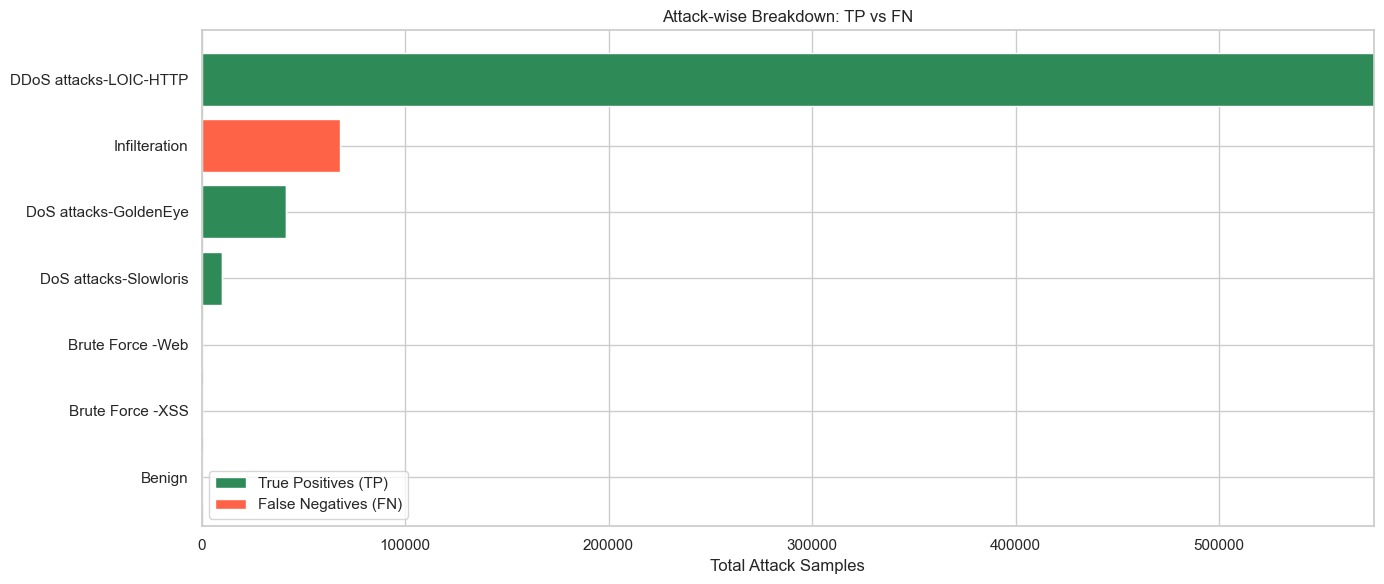

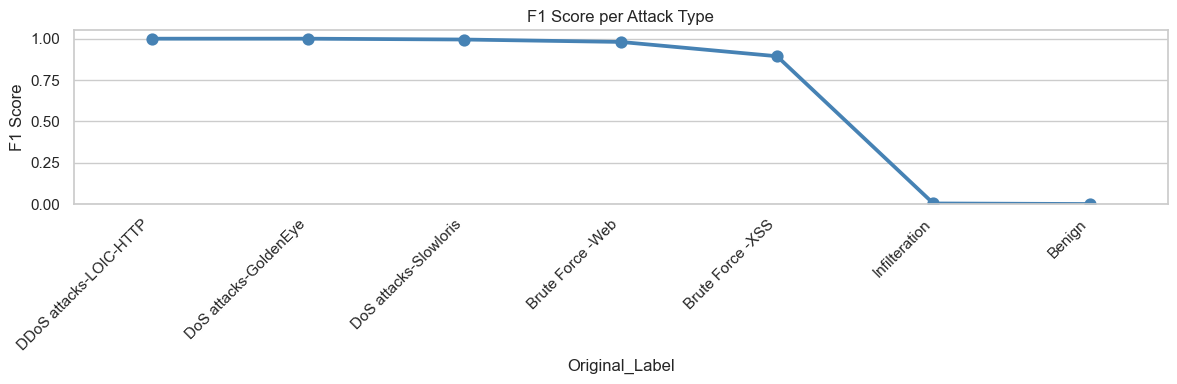

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# -------------------------------
# Load existing TP/FP/FN summary
# -------------------------------
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(summary_path)
print("Summary loaded:", df.shape)

# -------------------------------
# Derive Key Metrics
# -------------------------------
df["Total_Attacks"] = df["TP"] + df["FN"]
df["Detection_Rate(%)"] = round(100 * df["TP"] / df["Total_Attacks"], 2)
df["False_Positive_Rate(%)"] = round(100 * df["FP"] / (df["TP"] + df["FP"] + 1e-6), 2)

# Optional: F1 Score
df["Precision"] = df["TP"] / (df["TP"] + df["FP"] + 1e-6)
df["Recall"] = df["TP"] / (df["TP"] + df["FN"] + 1e-6)
df["F1_Score"] = round(2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"] + 1e-6), 4)

# Save enhanced version
enhanced_path = summary_path.replace(".csv", "_enhanced.csv")
df.to_csv(enhanced_path, index=False)
print(f"Enhanced summary saved to: {enhanced_path}")

# -------------------------------
# Barplot: Detection Rate (%)
# -------------------------------
plt.figure(figsize=(14, 6))
sns.barplot(data=df.sort_values("Detection_Rate(%)", ascending=False),
            x="Detection_Rate(%)", y="Original_Label", palette="viridis")
plt.title("Detection Rate (%) per Attack Type")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.xlim(0, 105)
plt.tight_layout()
plt.show()

# -------------------------------
# Stacked Bar: TP vs FN
# -------------------------------
df_stacked = df.sort_values("Total_Attacks", ascending=False)
plt.figure(figsize=(14, 6))
plt.barh(df_stacked["Original_Label"], df_stacked["TP"], color="seagreen", label="True Positives (TP)")
plt.barh(df_stacked["Original_Label"], df_stacked["FN"], left=df_stacked["TP"], color="tomato", label="False Negatives (FN)")
plt.xlabel("Total Attack Samples")
plt.title("Attack-wise Breakdown: TP vs FN")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -------------------------------
# Plot: F1 Score
# -------------------------------
plt.figure(figsize=(12, 4))
sns.pointplot(data=df.sort_values("F1_Score", ascending=False),
              x="Original_Label", y="F1_Score", color="steelblue", marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("F1 Score per Attack Type")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.05)
plt.tight_layout()
plt.show()


Enhanced summary saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv

INADS Core Layer – Attack Detection Summary:



,Original_Label,Total_Attacks,TP,FN,FP,Detection_Rate(%),Precision,Recall,F1_Score,False_Positive_Rate(%)
0,DDoS attacks-LOIC-HTTP,576175.0,576171.0,4.0,0.0,99.999306,1.0,1.0000,1.0000,0.0
1,DoS attacks-GoldenEye,41455.0,41453.0,2.0,0.0,99.995175,1.0,1.0000,1.0000,0.0
2,DoS attacks-Slowloris,10285.0,10180.0,105.0,0.0,98.979096,1.0,0.9898,0.9949,0.0
3,Brute Force -Web,362.0,348.0,14.0,0.0,96.132597,1.0,0.9613,0.9803,0.0
4,Brute Force -XSS,151.0,122.0,29.0,0.0,80.794702,1.0,0.8079,0.8937,0.0
5,Infilteration,68224.0,116.0,68108.0,0.0,0.170028,1.0,0.0017,0.0034,0.0
6,Benign,0.0,0.0,0.0,1201.0,0.000000,0.0,NaN,NaN,100.0


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1944579011.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


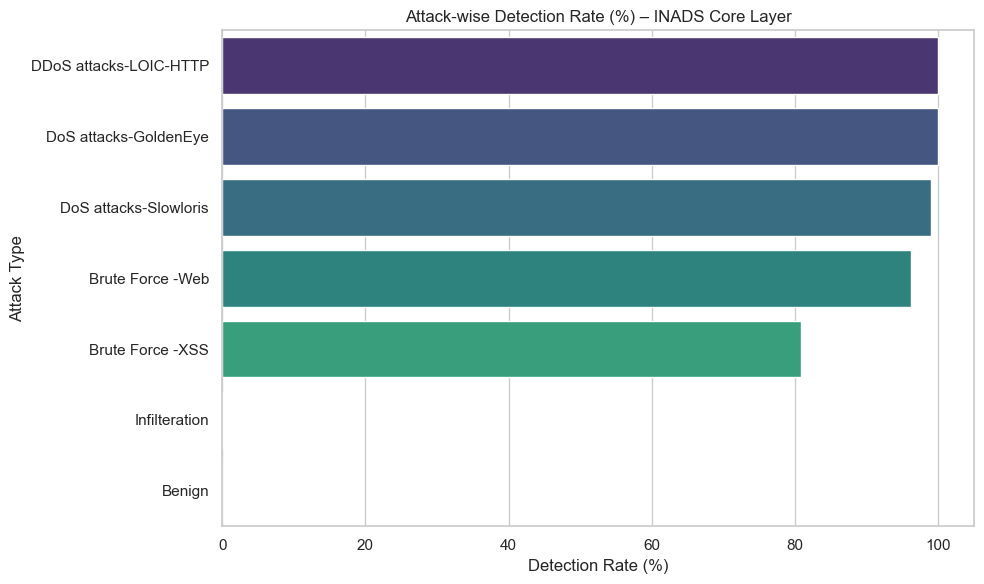

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load base summary
summary_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary.csv"
df = pd.read_csv(summary_path)

# Rename columns to avoid space-based duplicates
df.rename(columns={
    "Total Attacks": "Total_Attacks",
    "Detection Rate (%)": "Detection_Rate(%)"
}, inplace=True)

# Compute additional metrics safely
df["Precision"] = (df["TP"] / (df["TP"] + df["FP"])).round(4)
df["Recall"] = (df["TP"] / (df["TP"] + df["FN"])).round(4)
df["F1_Score"] = (2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])).round(4)
df["False_Positive_Rate(%)"] = ((df["FP"] / (df["TP"] + df["FP"])) * 100).round(2)

# Save enhanced version
enhanced_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_tp_fp_fn_summary_enhanced.csv"
df.to_csv(enhanced_path, index=False)
print(f"\nEnhanced summary saved to: {enhanced_path}")

# Display selected metrics
print("\nINADS Core Layer – Attack Detection Summary:\n")
display(df[[
    "Original_Label", "Total_Attacks", "TP", "FN", "FP", "Detection_Rate(%)",
    "Precision", "Recall", "F1_Score", "False_Positive_Rate(%)"
]])

# Optional: Horizontal barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.sort_values("Detection_Rate(%)", ascending=False),
    x="Detection_Rate(%)", y="Original_Label", palette="viridis"
)
plt.title("Attack-wise Detection Rate (%) – INADS Core Layer")
plt.xlabel("Detection Rate (%)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.savefig("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_attackwise_barplot.png")
plt.show()

In [95]:
print(results_df["Original_Label"].unique())

['Benign' 'Infilteration' 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris'
 'DDoS attacks-LOIC-HTTP' 'Brute Force -Web' 'Brute Force -XSS']


In [117]:
import pandas as pd

# -------------------------------
# Step 1: Load predictions and raw labels
# -------------------------------
results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
raw_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

df = pd.read_csv(results_path)
df_raw = pd.read_csv(raw_data_path)

# Attach original attack labels to results
df["Original_Label"] = df_raw["Label"][:len(df)]

# Add binary labels if missing
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = (df["True_Label"] == 1).astype(int)

# -------------------------------
# Step 2: Filter only attack samples for analysis
# -------------------------------
attack_df = df[df["Binary_Label"] == 1]

# -------------------------------
# Step 3: Define metric calculation function
# -------------------------------
def compute_metrics(group, pred_col):
    attack_total = len(group)
    tp = ((group["True_Label"] == 1) & (group[pred_col] == 1)).sum()
    fn = ((group["True_Label"] == 1) & (group[pred_col] == 0)).sum()
    detection_rate = 100 * tp / attack_total if attack_total > 0 else 0
    return pd.Series({
        f"{pred_col}_TP": tp,
        f"{pred_col}_FN": fn,
        f"{pred_col}_Detection(%)": round(detection_rate, 2)
    })

# -------------------------------
# Step 4: Run for each layer's predictions
# -------------------------------
layer_metrics = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([
    compute_metrics(g, "Final_Prediction"),
    compute_metrics(g, "Global_Confidence" if "Global_Prediction" not in g else "Global_Prediction"),
    compute_metrics(g, "Edge_Confidence" if "Edge_Prediction" not in g else "Edge_Prediction"),
    compute_metrics(g, "Device_Confidence" if "Device_Prediction" not in g else "Device_Prediction")
], axis=0))

# Optional: clean up the index
layer_metrics.reset_index(inplace=True)

# -------------------------------
# Step 5: Save and show
# -------------------------------
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"
layer_metrics.to_csv(output_path, index=False)

print(f"\nPer-attack detection summary saved to:\n{output_path}")
display(layer_metrics)


Per-attack detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/2645590937.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_metrics = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([


,Original_Label,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Confidence_TP,Global_Confidence_FN,Global_Confidence_Detection(%),Edge_Confidence_TP,Edge_Confidence_FN,Edge_Confidence_Detection(%),Device_Confidence_TP,Device_Confidence_FN,Device_Confidence_Detection(%)
0,Brute Force -Web,348.0,14.0,96.13,0.0,0.0,0.0,164.0,0.0,45.30,0.0,0.0,0.00
1,Brute Force -XSS,122.0,29.0,80.79,0.0,0.0,0.0,61.0,0.0,40.40,27.0,0.0,17.88
2,DDoS attacks-LOIC-HTTP,576171.0,4.0,100.00,0.0,0.0,0.0,444310.0,0.0,77.11,290001.0,0.0,50.33
3,DoS attacks-GoldenEye,41453.0,2.0,100.00,0.0,0.0,0.0,11333.0,0.0,27.34,27194.0,0.0,65.60
4,DoS attacks-Slowloris,10180.0,105.0,98.98,0.0,0.0,0.0,3176.0,0.0,30.88,0.0,0.0,0.00
5,Infilteration,116.0,68108.0,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.00


In [119]:
import pandas as pd

# Paths
core_results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
raw_data_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"

# Load predictions & raw labels
df = pd.read_csv(core_results_path)
df_raw = pd.read_csv(raw_data_path)

# Merge Original_Label
df["Original_Label"] = df_raw["Label"][:len(df)]

# Create Binary Ground Truth
df["Binary_Label"] = (df["Original_Label"] != "Benign").astype(int)

# Threshold each layer to get binary predictions
df["Global_Prediction"] = (df["Global_Confidence"] > 0.5).astype(int)
df["Edge_Prediction"] = (df["Edge_Confidence"] > 0.5).astype(int)
df["Device_Prediction"] = (df["Device_Confidence"] > 0.5).astype(int)

# Filter only attack rows
attack_df = df[df["Binary_Label"] == 1]

# Function to compute metrics per attack type
def compute_metrics(subdf, pred_col):
    total = len(subdf)
    tp = ((subdf[pred_col] == 1)).sum()
    fn = ((subdf[pred_col] == 0)).sum()
    detection = round((tp / total) * 100, 2) if total > 0 else 0.0
    return pd.Series({
        f"{pred_col}_TP": tp,
        f"{pred_col}_FN": fn,
        f"{pred_col}_Detection(%)": detection
    })

# Apply per-layer metrics by attack type
layer_metrics = attack_df.groupby("Original_Label").apply(
    lambda g: pd.concat([
        compute_metrics(g, "Final_Prediction"),
        compute_metrics(g, "Global_Prediction"),
        compute_metrics(g, "Edge_Prediction"),
        compute_metrics(g, "Device_Prediction"),
    ], axis=0)
).reset_index()

# Save and display
layer_metrics.to_csv(output_path, index=False)
print(f"\nPer-attack detection summary saved to:\n{output_path}")
display(layer_metrics)


Per-attack detection summary saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/3971820372.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_metrics = attack_df.groupby("Original_Label").apply(


,Original_Label,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Prediction_TP,Global_Prediction_FN,Global_Prediction_Detection(%),Edge_Prediction_TP,Edge_Prediction_FN,Edge_Prediction_Detection(%),Device_Prediction_TP,Device_Prediction_FN,Device_Prediction_Detection(%)
0,Brute Force -Web,348.0,14.0,96.13,362.0,0.0,100.0,338.0,24.0,93.37,149.0,213.0,41.16
1,Brute Force -XSS,122.0,29.0,80.79,151.0,0.0,100.0,86.0,65.0,56.95,72.0,79.0,47.68
2,DDoS attacks-LOIC-HTTP,576171.0,4.0,100.00,576175.0,0.0,100.0,576095.0,80.0,99.99,575862.0,313.0,99.95
3,DoS attacks-GoldenEye,41453.0,2.0,100.00,41455.0,0.0,100.0,41424.0,31.0,99.93,41427.0,28.0,99.93
4,DoS attacks-Slowloris,10180.0,105.0,98.98,10285.0,0.0,100.0,10110.0,175.0,98.30,9710.0,575.0,94.41
5,Infilteration,116.0,68108.0,0.17,68224.0,0.0,100.0,19.0,68205.0,0.03,95.0,68129.0,0.14


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1331546114.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_core, plot_type="bar", show=False)


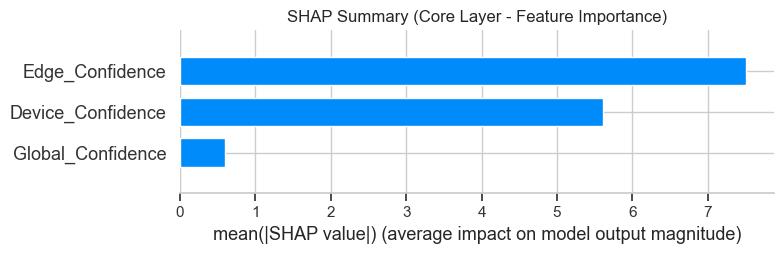

/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/1331546114.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_core)


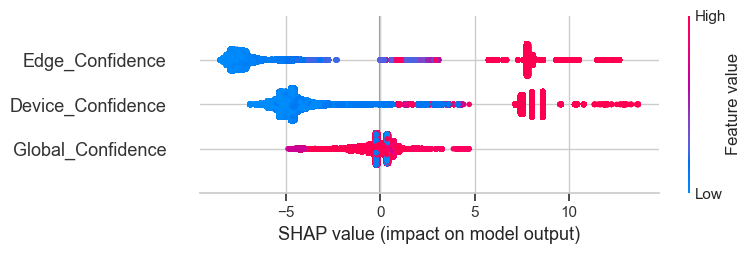

In [121]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Load your fused prediction results
core_df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Extract input features to the fusion model (these are the confidence scores from each layer)
X_core = core_df[["Global_Confidence", "Edge_Confidence", "Device_Confidence"]]
y_core = core_df["Final_Prediction"]

# Train a simple surrogate model for interpretability
surrogate = xgb.XGBClassifier(n_estimators=100, max_depth=3)
surrogate.fit(X_core, y_core)

# Use SHAP to explain predictions
explainer = shap.Explainer(surrogate)
shap_values = explainer(X_core)

# Plot global feature importance
shap.summary_plot(shap_values, X_core, plot_type="bar", show=False)
plt.title("SHAP Summary (Core Layer - Feature Importance)")
plt.tight_layout()
plt.savefig("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_shap_bar.png")
plt.show()

# Optional: Beeswarm for detailed view
shap.summary_plot(shap_values, X_core)

In [123]:
import pandas as pd
import numpy as np

# -------------------------------
# STEP 1: Load Core Prediction File
# -------------------------------
core_results_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv"
df = pd.read_csv(core_results_path)

# -------------------------------
# STEP 2: Load True Labels & Attack Names
# -------------------------------
label_path = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
df_labels = pd.read_csv(label_path)
df["Original_Label"] = df_labels["Label"][:len(df)]  # align correctly

# Binarize true label (0 = benign, 1 = attack)
df["Binary_Label"] = np.where(df["Original_Label"].str.lower() == "benign", 0, 1)

# -------------------------------
# STEP 3: Convert Confidence Scores to Binary Predictions
# -------------------------------
threshold = 0.5  # tunable threshold

df["Global_Prediction"] = (df["Global_Confidence"] > threshold).astype(int)
df["Edge_Prediction"] = (df["Edge_Confidence"] > threshold).astype(int)
df["Device_Prediction"] = (df["Device_Confidence"] > threshold).astype(int)
df["Final_Prediction"] = (df["Fused_Confidence"] > threshold).astype(int)

# -------------------------------
# STEP 4: Per-Attack Metric Calculation Function
# -------------------------------
def compute_detection_metrics(group, pred_col):
    tp = ((group["Binary_Label"] == 1) & (group[pred_col] == 1)).sum()
    fn = ((group["Binary_Label"] == 1) & (group[pred_col] == 0)).sum()
    detection = round((tp / (tp + fn)) * 100, 2) if (tp + fn) > 0 else 0
    return pd.Series({f"{pred_col}_TP": tp, f"{pred_col}_FN": fn, f"{pred_col}_Detection(%)": detection})

# -------------------------------
# STEP 5: Group by Attack Type and Apply for Each Layer
# -------------------------------
attack_df = df[df["Binary_Label"] == 1]

layerwise_df = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([
    compute_detection_metrics(g, "Final_Prediction"),
    compute_detection_metrics(g, "Global_Prediction"),
    compute_detection_metrics(g, "Edge_Prediction"),
    compute_detection_metrics(g, "Device_Prediction"),
], axis=0)).reset_index()

# Add total attacks for context
attack_counts = attack_df["Original_Label"].value_counts().reset_index()
attack_counts.columns = ["Original_Label", "Total_Attacks"]
layerwise_df = attack_counts.merge(layerwise_df, on="Original_Label")

# -------------------------------
# STEP 6: Save the Results
# -------------------------------
output_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv"
layerwise_df.to_csv(output_path, index=False)
print(f"Detection breakdown saved to:\n{output_path}")

# Optional Preview
display(layerwise_df)

Detection breakdown saved to:
/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/layerwise_attack_detection_comparison.csv


/var/folders/np/t44vfnk15zj6fnnj8h0mdmb40000gn/T/ipykernel_9322/2266664277.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layerwise_df = attack_df.groupby("Original_Label").apply(lambda g: pd.concat([


,Original_Label,Total_Attacks,Final_Prediction_TP,Final_Prediction_FN,Final_Prediction_Detection(%),Global_Prediction_TP,Global_Prediction_FN,Global_Prediction_Detection(%),Edge_Prediction_TP,Edge_Prediction_FN,Edge_Prediction_Detection(%),Device_Prediction_TP,Device_Prediction_FN,Device_Prediction_Detection(%)
0,DDoS attacks-LOIC-HTTP,576175,576171.0,4.0,100.00,576175.0,0.0,100.0,576095.0,80.0,99.99,575862.0,313.0,99.95
1,Infilteration,68224,116.0,68108.0,0.17,68224.0,0.0,100.0,19.0,68205.0,0.03,95.0,68129.0,0.14
2,DoS attacks-GoldenEye,41455,41453.0,2.0,100.00,41455.0,0.0,100.0,41424.0,31.0,99.93,41427.0,28.0,99.93
3,DoS attacks-Slowloris,10285,10180.0,105.0,98.98,10285.0,0.0,100.0,10110.0,175.0,98.30,9710.0,575.0,94.41
4,Brute Force -Web,362,348.0,14.0,96.13,362.0,0.0,100.0,338.0,24.0,93.37,149.0,213.0,41.16
5,Brute Force -XSS,151,122.0,29.0,80.79,151.0,0.0,100.0,86.0,65.0,56.95,72.0,79.0,47.68


In [125]:
import pandas as pd

# Load full results
df = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/core_layer_results.csv")

# Load original labels
df_raw = pd.read_csv("/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv")
df["Original_Label"] = df_raw["Label"][:len(df)].values
df["Binary_Label"] = (df["Original_Label"].str.lower() != "benign").astype(int)

# Let's inspect infiltration
infil_df = df[df["Original_Label"].str.lower() == "infilteration"]

# Ensure the predictions are present
if "Global_Prediction" not in df.columns:
    # Assuming threshold > 0.5 on confidence gives 1
    df["Global_Prediction"] = (df["Global_Confidence"] > 0.5).astype(int)
    infil_df = df[df["Original_Label"].str.lower() == "infilteration"]

# Now compute TP, FN
tp = ((infil_df["Binary_Label"] == 1) & (infil_df["Global_Prediction"] == 1)).sum()
fn = ((infil_df["Binary_Label"] == 1) & (infil_df["Global_Prediction"] == 0)).sum()

# Detection Rate
detection_rate = round(100 * tp / (tp + fn), 4) if (tp + fn) > 0 else 0

print(f"Infiltration Global Detection:\nTP = {tp}, FN = {fn}, Detection Rate = {detection_rate}%")

Infiltration Global Detection:
TP = 68224, FN = 0, Detection Rate = 100.0%


In [127]:
print("Number of unique rows used for training:", len(set(xgb_model.get_booster().get_dump())))
print("Number of rows in Global Confidence output:", len(df))

Number of unique rows used for training: 2100
Number of rows in Global Confidence output: 2270313
